# Import Libraries

In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

# Load train and test test and apply transformation

In [2]:
apply_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
BatchSize = 256 # change according to system specs

trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=4) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,shuffle=False, num_workers=4)

D:\software\anaconda3\envs\anupam\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Print an image from MNIST

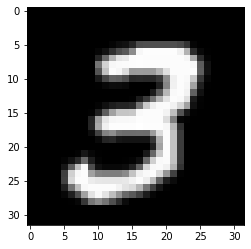

In [19]:
x, y = trainset[7] # x is now a torch.Tensor
plt.imshow(x[0], cmap='gray')

In [17]:
print(y)

3


# Size of the image 

In [13]:
print(x.size())

torch.Size([1, 32, 32])


# Print Size of train and test set

In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


# Defination of the Model

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# GPU or CPU allocation

In [5]:
use_gpu = torch.cuda.is_available()
net = LeNet()
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Training

In [6]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.1
num_epochs = 5

train_loss = []
train_acc = []
for epoch in range(num_epochs):
    
    running_loss = 0.0 
    running_corr = 0
        
    for i,data in enumerate(trainLoader):
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        net.zero_grad() 
        # Data feed-forward through the network
        outputs = net(inputs)
        # Predicted class is the one with maximum probability
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss
        loss = criterion(outputs, labels)
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds==labels)    
        
    totalLoss = running_loss/(i+1)
    # Calculating gradients
    totalLoss.backward()
    # Updating the model parameters
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)
        
    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/60000
    
    
         
    train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
       
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))

D:\software\anaconda3\envs\anupam\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/5 : Training loss: 2.3039 | Training Accuracy: 9.7517
Epoch 2/5 : Training loss: 2.3037 | Training Accuracy: 9.7517
Epoch 3/5 : Training loss: 2.3034 | Training Accuracy: 9.7517
Epoch 4/5 : Training loss: 2.3032 | Training Accuracy: 9.7517
Epoch 5/5 : Training loss: 2.3030 | Training Accuracy: 9.7517


# Loss and Accuracy Curve

Text(0, 0.5, 'Training')

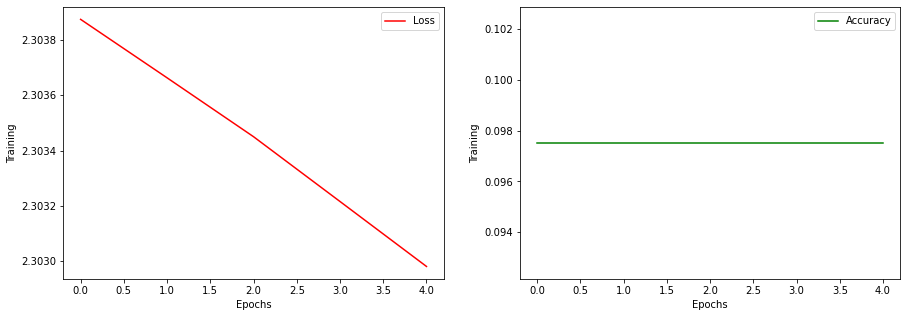

In [7]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss,'r-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

# Testing the model

In [8]:
correct_pred = 0
for data in testLoader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/10000.0
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  9.74
